# PotentioDynamic Scattering Microscopy (PDSM)

## Contrast oscillation analysis
 
Author: ``Sanli Faez (s.faez@uu.nl)``

last update: 14/3/2018
v0.1: 27/2/2018

The main use of this notebook is to **test on a small scale** the functions necessary for extracting the scattering contrast oscillations.  

The measurements are done using the a TIR scattering microscope at the surface of a transparent slab while an alternating potential is applied. The setup in Oxford uses labview and creates tdms datafiles. The setup in Utrecht generates HDF5 files. The rest of the analysis should be the same.

### General advice
Use the notebook for testing small datasets, or fractions of larger ones. Once the reliability is verfied, add the code pieces to an script and process batches of data.

#### Addendum
For now, it is hards to converge on a very general treatments that can be applied to batches. Data should be analyzed with ample supervision to avoid misleading results.


### Roadmap
Each step is separately tested and verified.

* Part 1) preprocessing and previewing data
* Part 2) Consructing the contrast oscillation map
* Part 3) Summarizing the sequence in a representative plot
* Part 4) NOT READY! Comparing responses for different conditions


In [1]:
%pylab inline

import sys
sys.path.append('/Users/sanli/Repositories/PDSM') #uncomment including extra files are needed

import matplotlib.pyplot as plt
import numpy as np
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# choose filename and output directory
fdir = r'/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/Shawn/190313/25nM BSA in 2mM NaCl on ITO_1ms_12mW_1.8Vpp triangle EF 1Hz_200fps/'
mfile = 'event2.tdms'
fext = '.tdms'
fpath = fdir + mfile
print(fpath)
#outputdir = fdir + 'analyzed/' + mfile.strip(fext) + '/'
outputdir = fdir

/Users/sanli/Repositories/Data/PDSM_UnderInvestigation/Shawn/190313/25nM BSA in 2mM NaCl on ITO_1ms_12mW_1.8Vpp triangle EF 1Hz_200fps/event2.tdms


### Import data from recorded image sequence files
- The cell after workds only for TDMS files from Oxford.

Use the other notebook for HDF5 videos that are recorded in Utrecht 


In [3]:
# Import TDMS (Shawn's setup) data:
import nptdms  #needed for image-series that are recorded with Labview

attributes=nptdms.TdmsFile(fpath).object("img","cam2").properties  # cam2 is specific to Shawn's setup, for some iSCAT setups this has to be cam1
print(attributes)
efr = attributes['Frame Rate']

f = nptdms.TdmsFile(fpath)
data_raw = f.channel_data('img', 'cam2')
attributes = f.object("img" , 'cam2').properties
Ly = int(attributes['Pixel Size'])
Lx = Ly
nf = data_raw.size//(Ly*Lx)
frames = data_raw[:nf*Lx*Ly].reshape(nf, Ly, Lx)
# frames = tdms.read_tdms(filename, do_remove_empty_frames=False, do_check_no_duplicates=False)
print(nf, "frames in the sequence")
firstline = np.mean(frames[:,20,:], axis=1)
print(frames.shape)

OrderedDict([('Frame Rate', 200.0), ('Exposure Time', 0.0), ('Bin Frame Size', 1.0), ('Pixel Size', 512.0), ('Lost frames during acq', 0.0)])
3800 frames in the sequence
(3800, 512, 512)


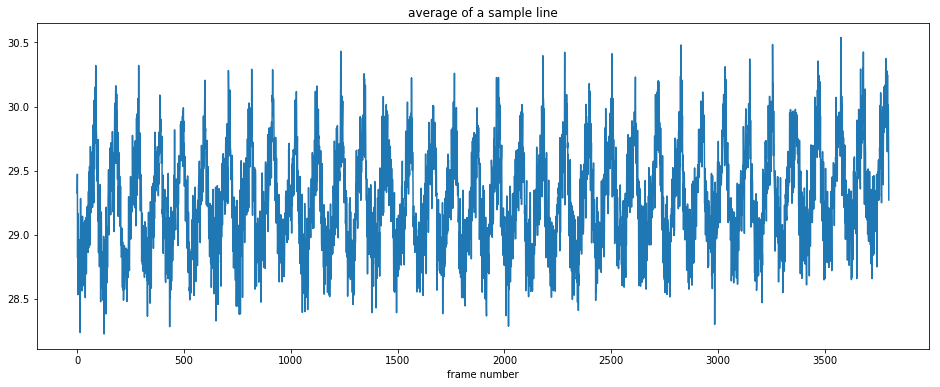

In [4]:
if not os.path.exists(outputdir):
    os.makedirs(outputdir)
fig = plt.figure(figsize=(16,6))
plt.plot(firstline[:nf])
plt.title("average of a sample line")
plt.xlabel("frame number")
plt.show()
previewfile = outputdir + mfile.strip(fext) +'_singleline'
fig.savefig(previewfile)

In [5]:
# It might be necessary to skip part of the recorded video because of shaking. Use this cell to choose the stable part
# or skip to the next cell if all is good.

### Divide the variance by the average to find oscilating spots/patterns
For shot-noise limited background, this valus should be equal to one. Any excess amount means either technical noise (shaking/drift) or induced perturbasion (potentiodynamic contrast) 

In [6]:
nmean = 600 #choosing just a few oscillations cycles to save time
mean_img = np.mean(frames[:nmean], axis=0)
dark = 2 # very important to put the correct value for camera dark counts
mean_img = mean_img - dark

## few lines to look at the differential variation signal rather than the images
# dframes = np.copy(frames)    
# for i in range(nf):
#     dframes[:,:,i] = frames[:,:,i] - mean_img
    
print(f"average counts:{np.mean(mean_img)}, minimum counts:{np.min(mean_img)}")

var_img = np.std(frames[:nmean], axis=0)
print(f"average variance:{np.mean(var_img)}, minimum variance:{np.min(var_img)}")

contrast_img = var_img/np.sqrt(mean_img)

# nbins = 40
# hist_img, bin_edges_img = np.histogram(contrast_img, bins = nbins)
# hist_var, bin_edges_var = np.histogram(var_img, bins = nbins)

average counts:51.79111157735189, minimum counts:0.3966666666666665
average variance:4.7086905874072755, minimum variance:1.2881468170291075


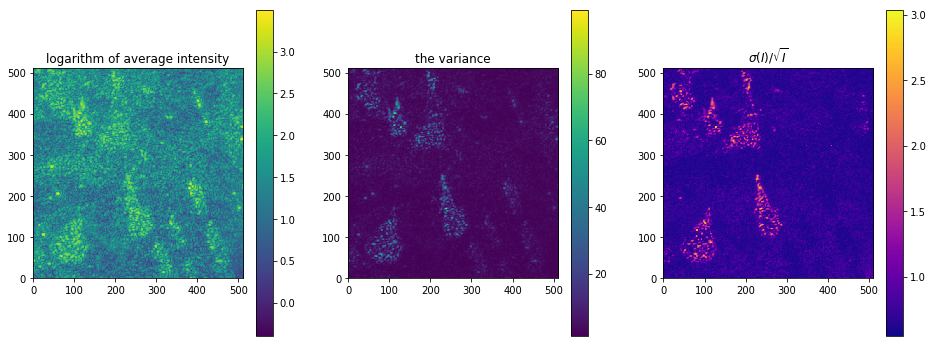

In [7]:
fig = plt.figure(figsize=(16,6))
ax1 = plt.subplot(131)
im1 = ax1.imshow(np.log10(mean_img), origin ='lower')
plt.colorbar(im1, ax = ax1)
plt.title("logarithm of average intensity")

ax2 = plt.subplot(132)
im2 = ax2.imshow(var_img, origin ='lower')
plt.colorbar(im2, ax = ax2)
plt.title("the variance")

ax3 = plt.subplot(133)
im3 = ax3.imshow(contrast_img, cmap='plasma', origin ='lower')
plt.colorbar(im3, ax = ax3)
plt.title(r'$\sigma(I)/\sqrt{I}$')

# ax4 = plt.subplot(224)
# im4 = ax4.semilogy(bin_edges_var[:nbins], hist_var, '.-')
# plt.title("Distribution of standard deviation")

previewfile = outputdir + mfile.strip(fext)+'_contrast.png'
fig.savefig(previewfile)
plt.show()

### Choose one speckle spot to find the oscillation frequency and waveform
To observe a clear oscillation, use the spot with highest variance/mean value. Adding a few neighboring pixels to that spot increases the signal to noise.

max variations at  (168, 238)
least variations at  (33, 287)
relative intensity variation 0.0865940123408


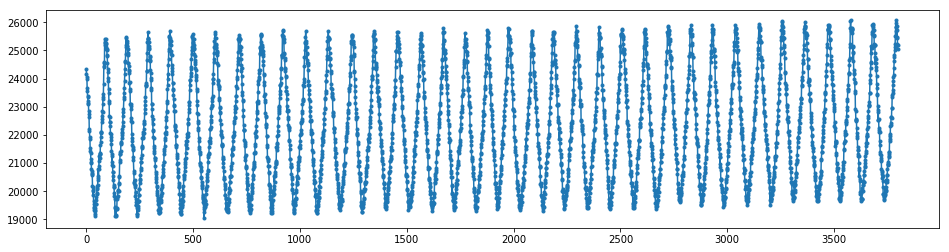

In [8]:
spotmax = np.unravel_index(np.argmax(var_img, axis=None), var_img.shape)
spotmin = np.unravel_index(np.argmin(var_img, axis=None), var_img.shape)

# spotmax = [spotmax[0], spotmax[1]]
print("max variations at ", spotmax)
print("least variations at ", spotmin)
#spotmax = (210, 150)
psw = 3 # esitmate fwhm of the speckle peak
specklemax = frames[:, spotmax[0]-psw:spotmax[0]+psw+1, spotmax[1]-psw:spotmax[1]+psw+1]
responsemax = np.sum(np.sum(specklemax, axis = 1), axis = 1)
specklemin = frames[:, spotmin[0]-psw:spotmin[0]+psw+1, spotmin[1]-psw:spotmin[1]+psw+1]
responsemin = np.sum(np.sum(specklemin, axis = 1), axis = 1)

varspotmax = np.std(responsemax)/np.mean(responsemax)
print("relative intensity variation", varspotmax)

fig = plt.figure(figsize=(16,4))
plt.plot(responsemax, '.-')
#plt.plot(responsemin)
plt.show()

### Find the Fourier component(s) corresponding to the oscillating potential
This part can be tricky if the oscillations are not prominent. Choose dcbase so that the value at the lower components is less that the peak value on the spectrum. 

Also check for presence of higher harmonics.

Fourier components: 36


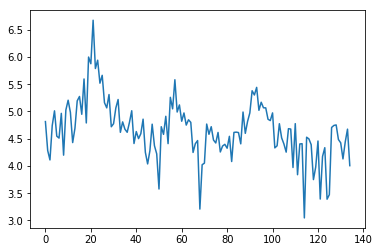

In [9]:
fspec = np.fft.rfft(responsemax)

maxfc = 150 #fourier index above which is irrelevant for the analysis
dcbase = 15   #fourier index below which counts as drift
plt.plot(np.log10(abs(fspec[dcbase:maxfc])))
# plt.plot(np.angle(fspec[dcbase:220]))

mfreq = dcbase + np.argmax(abs(fspec[dcbase:maxfc]))
#shfreq = mfreq + dcbase + np.argmax(abs(fspec[mfreq + dcbase:]))
#thirdfreq = shfreq + dcbase + np.argmax(abs(fspec[shfreq + dcbase:]))

print("Fourier components:", mfreq)
#plt.plot(np.arange(mfreq-1,mfreq+2), abs(fspec[mfreq-1:mfreq+2]), '.')
plt.show()


### Map the fourier components
The first cell is the most computation intensive part. The second cell is only for rendering the outcome.

In [10]:
## if you're just checking background noise, comment following lines when analyzing oscillating contrasts
# mfreq = 27
# shfreq = 63

# to save testing time, generate harmonic contrast images on smaller areas
region = 0

if region == 0:  # a small region for first test
    xminf, xmaxf = 0, 180
    yminf, ymaxf = 350, 500
elif region == 1:
    xminf, xmaxf = 0, 256
    yminf, ymaxf = 0, 256
elif region == 2: 
    xminf, xmaxf = 0, 256  #alternative region
    yminf, ymaxf = 257, Ly
elif region == 3: 
    xminf, xmaxf = 257, Lx  #alternative region
    yminf, ymaxf = 257, Ly
elif region == 4: 
    xminf, xmaxf = 257, Lx  #alternative region
    yminf, ymaxf = 0, 256
    
selection = frames[:, xminf:xmaxf, yminf:ymaxf] 
meansel = mean_img[xminf:xmaxf, yminf:ymaxf]
varsel = var_img[xminf:xmaxf, yminf:ymaxf]


ffpwidth = 2 #estimated half width of the Fourier peak in the power spectrum
frames_fft = np.fft.rfft(selection, axis=0)/nf
first_harmonic = np.sum(np.power(np.abs(frames_fft[mfreq-ffpwidth:mfreq+ffpwidth+1]),2), axis=0)

phase = np.angle(frames_fft[mfreq])/np.pi

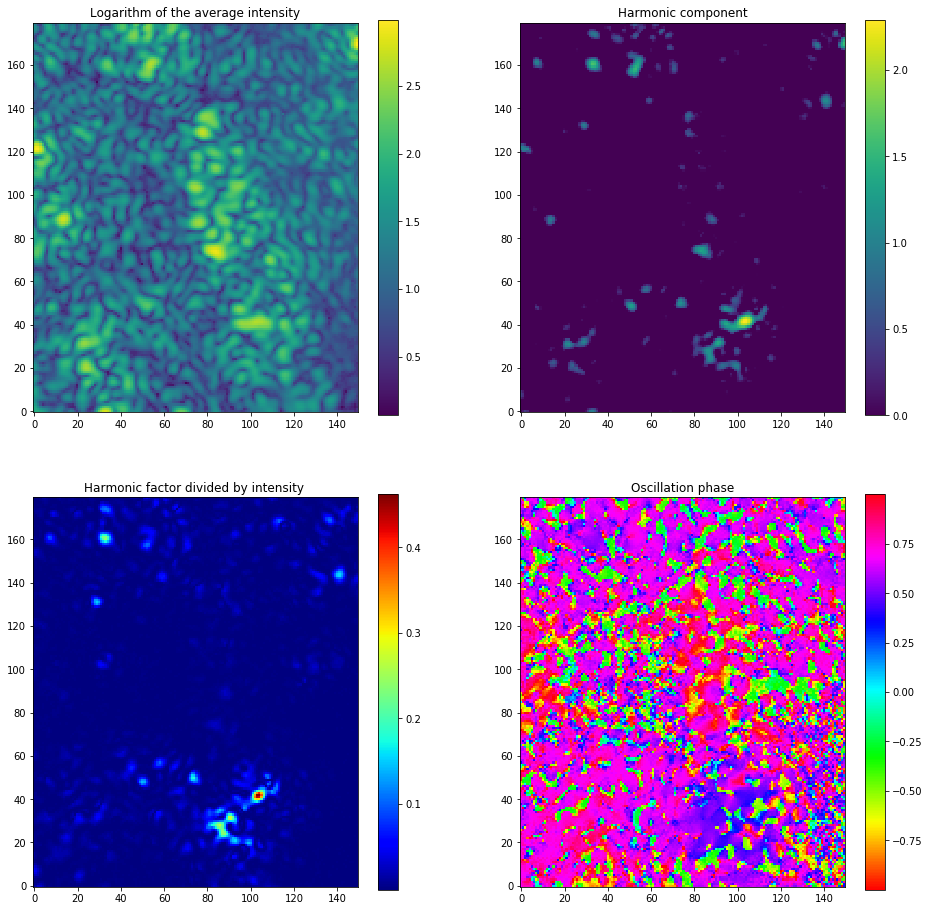

In [11]:
seltag = "corners"+str(xminf)+"x"+str(yminf)+"x"+str(xmaxf)+"x"+str(ymaxf)

fftmax = np.unravel_index(np.argmax(first_harmonic, axis=None), first_harmonic.shape)
# print(fftmax+[xminf, yminf])
fig = plt.figure(figsize=(16,16))

ax1 = plt.subplot(221)
im = ax1.imshow(np.log10(mean_img[xminf:xmaxf, yminf:ymaxf]), origin ='lower')
plt.colorbar(im, ax = ax1)
plt.title("Logarithm of the average intensity")

ax2 = plt.subplot(222)
im = ax2.imshow(np.log10(first_harmonic), vmin=0, origin ='lower')
plt.colorbar(im, ax = ax2)
plt.title("Harmonic component")

ax3 = plt.subplot(224)
im = ax3.imshow(phase, cmap='hsv', origin ='lower')
plt.colorbar(im, ax = ax3)
plt.title("Oscillation phase")

ax4 = plt.subplot(223)
im = ax4.imshow(first_harmonic/mean_img[xminf:xmaxf, yminf:ymaxf], cmap='jet', origin ='lower')
plt.colorbar(im, ax = ax4)
plt.title("Harmonic factor divided by intensity ")



# nbins = 40
# hist_harmonic, bin_edges_harmonic = np.histogram(first_harmonic/nf, bins = nbins)

# ax4 = plt.subplot(224)
# ax4.semilogy(bin_edges_harmonic[:nbins], hist_harmonic, '*-')
# ax4.semilogy(bin_edges_var[:nbins], hist_var, '.-')
# plt.title("Distribution of harmonic amplitudes and STD")

plt.show()

# saving some of the data
previewfile = outputdir + mfile.strip(fext)+seltag+'_Summary.png'
fig.savefig(previewfile)

output = outputdir + mfile.strip(fext)+seltag+'_firstharmonic.npy'
np.save(output, first_harmonic)

### Plot intensity vs time at interesting spots

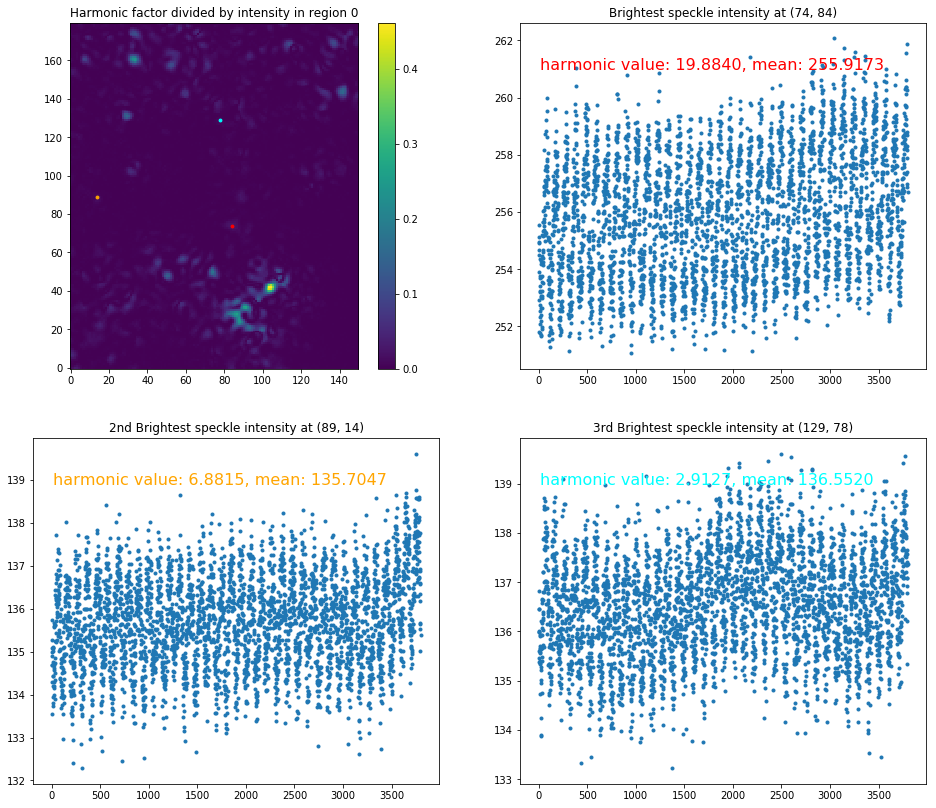

(3, 3800)


In [12]:
wx, wy = 5, 5  #estimated half width of speckle size, check that phase is constant over this area
bx, by = meansel.shape[0], meansel.shape[1]
selminmarg = np.copy(meansel)
selminmarg[:wx+1,:] = 0
selminmarg[bx-wx:,:] = 0
selminmarg[:, :wy+1] = 0
selminmarg[:, by-wy:] = 0 #to make sure chosen spots are not too close to the edges


fig = plt.figure(figsize=(16,14))

ax1 = plt.subplot(221)
im = ax1.imshow(first_harmonic/mean_img[xminf:xmaxf, yminf:ymaxf], vmin=0, origin ='lower')
plt.colorbar(im, ax = ax1)
plt.title(f"Harmonic factor divided by intensity in region {region}")

mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)
avg_spot = np.mean(np.mean(selection[:, mx-wx:mx+wx+1, my-wy:my+wy+1], axis=1), axis=1)
spots = [avg_spot]
fh = first_harmonic[mx, my]
si = np.mean(avg_spot)

ax2 = plt.subplot(222)
ax2.plot(avg_spot,'.')
ax1.scatter(my, mx, s=8, c='red', marker='o')
plt.title(f"Brightest speckle intensity at {mx, my}")
ax2.text(0.05,0.9, "harmonic value: %0.4f, mean: %0.4f"%(fh, si), transform=ax2.transAxes,
      fontsize=16, color = 'red', va='top')

selminmarg[mx-wx:mx+wx+1, my-wy:my+wy+1] = 0  # going for the second brightest peak
mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)
avg_spot = np.mean(np.mean(selection[:, mx-wx:mx+wx+1, my-wy:my+wy+1], axis=1), axis=1)
fh = first_harmonic[mx, my]
si = np.mean(avg_spot)
spots = numpy.concatenate([spots, [avg_spot]], axis=0)

ax3 = plt.subplot(223)
ax3.plot(avg_spot,'.')
ax1.scatter(my, mx, s=8, c='orange', marker='o')
plt.title(f"2nd Brightest speckle intensity at {mx, my}")
ax3.text(0.05,0.9, "harmonic value: %0.4f, mean: %0.4f"%(fh, si), transform=ax3.transAxes,
      fontsize=16, color = 'orange', va='top')


selminmarg[mx-wx:mx+wx+1, my-wy:my+wy+1] = 0  # going for the second brightest peak
mx, my = np.unravel_index(np.argmax(selminmarg), selminmarg.shape)
avg_spot = np.mean(np.mean(selection[:, mx-wx:mx+wx+1, my-wy:my+wy+1], axis=1), axis=1)
fh = first_harmonic[mx, my]
si = np.mean(avg_spot)
spots = numpy.concatenate([spots, [avg_spot]], axis=0)

ax4 = plt.subplot(224)
ax4.plot(avg_spot,'.')
ax1.scatter(my, mx, s=8, c='cyan', marker='o')
plt.title(f"3rd Brightest speckle intensity at {mx, my}")
ax4.text(0.05,0.9, "harmonic value: %0.4f, mean: %0.4f"%(fh, si), transform=ax4.transAxes,
      fontsize=16, color = 'cyan', va='top')

plt.show()

print(spots.shape)
output = outputdir + mfile.strip(fext) + seltag + '_spots.png'
fig.savefig(output)

output = outputdir + mfile.strip(fext)+ seltag +'_spots.npy'
np.save(output, spots)

### Find the average waveform for selected points

For datasets where the absolute phase is unknown, one spot should be chonse as the reference phase for the waveform.

here we take the following steps:
* use the reference spot to find the frequency and phase from a linear fit to the peak position
* use fft to filter the waveform and compare with generated triangle wave
* plot relative change of intensity vs applied voltage

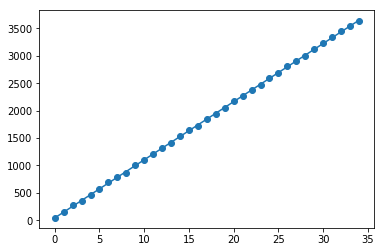

35 peaks with periodicity 106.10028011204483 and amplitude 1.838135524762322
ref trace with period 106.10028011204483 and lag 16.141596638656715


In [13]:
from PDSM_func import AvgWaveForm as awf

vpp = 0.9# Note: waveform amplitude goes from -vpp + vbase to vpp + vbase
real_period = 1 #The applied waveform period in Hz
vbase = 0.0
wf = "triangle" # or "square" or "sine" ##use this syntax
nper_plot = 6 # number of cycles to plot
# wf_duty = 0.50  # duty cycle of the wave

# use a reference spot to find the frequency and phase of the waveform, good ref spots are from ITO shiny regions
ref_spot = 1   #row index in the variable spots

ref_signal = spots[ref_spot,:nf]
ref_avg = np.mean(spots[ref_spot,:nf])
lag_correction = 0 #extra correction to correct for possible mistake in estimation of lag

# there are two functions for finding the periodicity
# find_period_peakfit uses the maxima and _minfit uses the minima. The give same periodicity but different phases

wf_period, wf_lag = awf.find_period_peakfit(ref_signal, guess=100, show_plot = True)
#wf_period = 109
wf_lag = wf_lag + lag_correction
halfper = int(wf_period/2)
print(f"ref trace with period {wf_period} and lag {wf_lag}")

### using the extracted periodicity, we can now make a cyclic plot

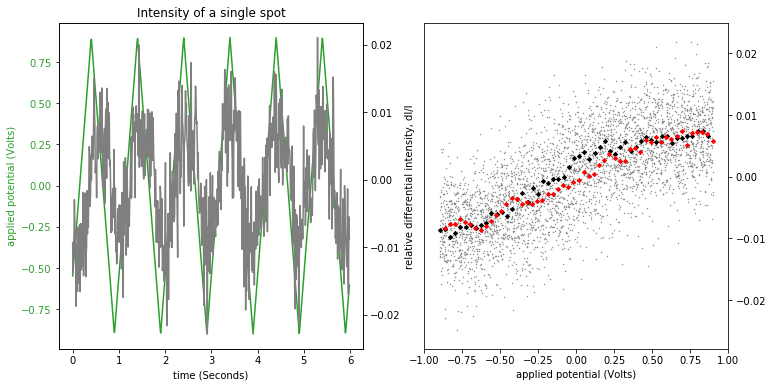

Int-V curve of slope 0.010375457771837675, intercept 4.2964252050460924e-05, error 0.000253502171556314


In [14]:
# creates the waveform, better would be to measure it directly
applied_wf = awf.triangle_wf(nf, wf_period, wf_lag, vpp)
applied_single_period = awf.triangle_wf(int(wf_period), wf_period, - wf_period/4 -1, vpp)

ref_signal_nomean = (ref_signal - np.mean(ref_signal))/ref_avg
ref_signal_filtered = awf.fft_flat(ref_signal, wf_period)/ref_avg
ref_signal_single_period = awf.avg_single_period(ref_signal_filtered, wf_period, wf_lag)
taxis = real_period * np.arange(int(nper_plot*wf_period))/ wf_period

###Plotting the change of intensity over the sequence
fig = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
color = 'tab:green'
#ax1.plot(ref_signal_nomean[:int(nper_plot*wf_period)])

plt.title("Intensity of a single spot")
ax1.set_xlabel('time (Seconds)')
ax1.set_ylabel('applied potential (Volts)', color=color)  # we already handled the x-label with ax1
ax1.plot(taxis, applied_wf[:int(nper_plot*wf_period)], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.plot(taxis, ref_signal_filtered[:int(nper_plot*wf_period)], color=color)
ax2.set_ylabel('relative differential intensity, dI/I')

#fig.tight_layout()

ax3 = plt.subplot(122)
ax3.scatter(applied_wf, ref_signal_filtered, color = 'grey', s=0.2)
ax3.scatter(applied_single_period[:halfper], ref_signal_single_period[:halfper], c = 'k', marker="D", s=8)
ax3.scatter(applied_single_period[halfper:], ref_signal_single_period[halfper:], c = 'r', marker="D", s=8)
ax3.set_xlabel('applied potential (Volts)')
ax3.yaxis.tick_right()

plt.show()
#
outputfile = fdir + mfile.strip(fext) + 'WF_spot' + str(ref_spot) + '_reference.png'
fig.savefig(outputfile)

import scipy.stats as spstat
slope, intercept, r_value, p_value, std_err = spstat.linregress(applied_single_period, ref_signal_single_period)
print(f"Int-V curve of slope {slope}, intercept {intercept}, error {std_err}")

### using the phase of the reference spot make a cyclic plot for another point and check the slope

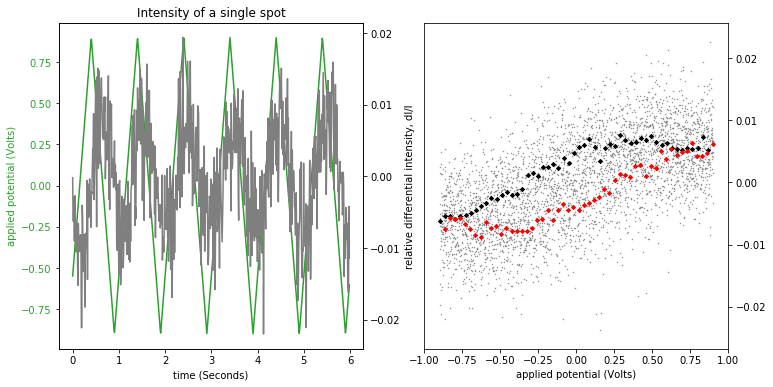

Int-V curve of slope 0.00823588766710304, intercept 2.672222579436135e-05, error 0.000562439533063623


In [15]:
particle_spot = 2 

particle_signal = spots[particle_spot,:nf]
particle_avg = np.mean(spots[particle_spot,:nf])
particle_signal_filtered = awf.fft_flat(particle_signal, wf_period)/particle_avg
particle_signal_single_period = awf.avg_single_period(particle_signal_filtered, wf_period, wf_lag)

###Plotting the change of intensity over the sequence
fig2 = plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
color = 'tab:green'

plt.title("Intensity of a single spot")
ax1.set_xlabel('time (Seconds)')
ax1.set_ylabel('applied potential (Volts)', color=color)  # we already handled the x-label with ax1
ax1.plot(taxis, applied_wf[:int(nper_plot*wf_period)], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:gray'
ax2.plot(taxis, particle_signal_filtered[:int(nper_plot*wf_period)], color=color)
ax2.set_ylabel('relative differential intensity, dI/I')

#fig.tight_layout()

ax3 = plt.subplot(122)
ax3.scatter(applied_wf, particle_signal_filtered, color = 'grey', s=0.2)
ax3.scatter(applied_single_period[:halfper], particle_signal_single_period[:halfper], c = 'k', marker="D", s=8)
ax3.scatter(applied_single_period[halfper:], particle_signal_single_period[halfper:], c = 'r', marker="D", s=8)
ax3.set_xlabel('applied potential (Volts)')
ax3.yaxis.tick_right()

plt.show()
#
outputfile = fdir + mfile.strip(fext) + 'WF_spot' + str(particle_spot) + '_particle.png'
fig2.savefig(outputfile)

slope, intercept, r_value, p_value, std_err = spstat.linregress(applied_single_period, particle_signal_single_period)
print(f"Int-V curve of slope {slope}, intercept {intercept}, error {std_err}")


## LATER: compare harmonic components on the same spot at different measurement conditions

### Relate the magnitude of the harmonic coefficient to the amplitude of the oscillation